In [107]:
import matplotlib.image as mpimg
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN

In [108]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [110]:
import os

path = "/content/drive/MyDrive/ML PROJECTS/Mole_Segmenation/"
print(os.listdir(path))


['MoleSegmentation-Dermatology.ipynb', 'mole_images', 'lab2_moles.zip', 'lab3_moles.pdf', '.ipynb_checkpoints']


In [111]:
filein = r"/content/drive/MyDrive/ML PROJECTS/Mole_Segmenation/mole_images/medium_risk_16.jpg"
im_or = mpimg.imread(filein) # function from the matplotlib.image module that reads an image file into a NumPy array
print(f"the shape of raw image is: {im_or.shape}")

the shape of raw image is: (583, 584, 3)


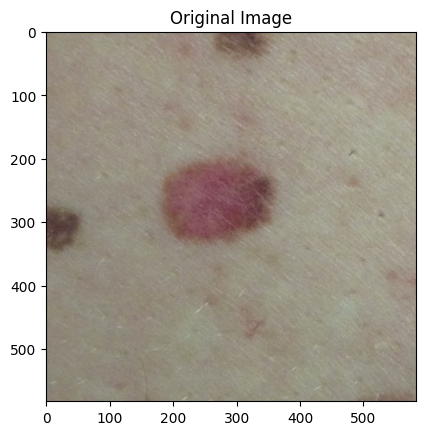

In [112]:
#Showing the picture
plt.figure()
plt.imshow(im_or, interpolation=None)
plt.title("Original Image")
plt.show()

In [113]:
#Instantiate the k-means object
kmeans = KMeans(n_clusters=3, random_state=0)
[N1,N2,N3]=im_or.shape   # Height, width, and color channels
im_2D=im_or.reshape((N1*N2,N3)) # N1*N2 rows and N3 columns
kmeans.fit(im_2D)   # KMeans model is trained on the 2D pixel data, grouping similar colors into 3 clusters based on the RGB values

KMeans(n_clusters=3, random_state=0)

In [114]:
centroids = kmeans.cluster_centers_.astype("uint8") #contains the RGB values of the 3 dominant colors in the image.
print(f"clusters in (3,3) shape: \n{centroids} \nContains RGB values of the 3 dominant colors in the image.")


clusters in (3,3) shape: 
[[162 156 141]
 [123  86  84]
 [147 139 125]] 
Contains RGB values of the 3 dominant colors in the image.


In [115]:
# create a quantized version (change the points value to its centroid value) of the original image, where each pixel is replaced by the color of its corresponding cluster centroid
im_or_2d_quant = im_2D.copy()
Ncluster = len(kmeans.cluster_centers_) # claster quantity
print(f"quantity of pixels in the image ('583*584'): {kmeans.labels_.shape}")
# quantity of pixels in the image (after reshaping it into a 2D array).

quantity of pixels in the image ('583*584'): (340472,)


In [116]:
for kc in range(Ncluster):
# this line finds all pixels that belong to that cluster by checking Kmeans.labels_ == kc.
# Kmeans.labels_ contains the cluster assignment(cluster name which difine by a number) for each pixel, so Kmeans.labels_ == kc creates a mask identifying which pixels belong to cluster kc.
# The pixels in im_or_2d_quant that belong to cluster kc are then assigned the RGB values of the centroid of that cluster (centroids[kc, :]), effectively replacing them with the dominant color of the cluster.
    im_or_2d_quant[(kmeans.labels_ == kc), :] = centroids[kc, :]
    im_quant = im_or_2d_quant.reshape((N1, N2, N3))
print(f"the shape of im_quant: {im_quant.shape}")

the shape of im_quant: (583, 584, 3)


Text(0.5, 1.0, 'Quantized Image')

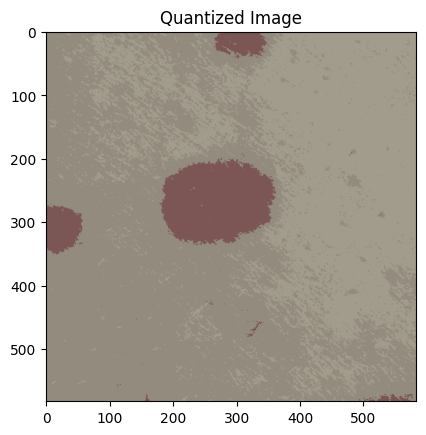

In [117]:
# showing the quantized image
plt.figure()
plt.imshow(im_quant, interpolation=None)
plt.title("Quantized Image")

In [118]:
## # identifies the darkest color among the KMeans centroids, locates pixels of that color in the image, and then clusters those positions using the DBSCAN algorithm
Kmeans_centroids=centroids  #These centroids represent the RGB values of each cluster.
conv_to_gray = np.array([0.2125, 0.7154, 0.0721])  # RGB to grayscale conversion coefficients
centroids_gray = centroids@conv_to_gray # converting each centroid to a grayscale value. The result, centroids_gray, is a 1D array where each element represents the grayscale brightness of one cluster.
i_col = centroids_gray.argmin()  # finds the index of the cluster with the smallest grayscale value (i.e., the darkest color) by finding the minimum value in centroids_gray. i_col will store the index of the darkest cluster
print(f"k-means centroids: \n{Kmeans_centroids}")
print(f" \nGray_scaled centroids: \n{centroids_gray}")
print(f"\nCluster_no. with the smallest grayscale value ({centroids_gray[1]})  is: {i_col}")

k-means centroids: 
[[162 156 141]
 [123  86  84]
 [147 139 125]]
 
Gray_scaled centroids: 
[156.1935  93.7183 139.6906]

Cluster_no. with the smallest grayscale value (93.7183)  is: 1


In [119]:
im_clust = kmeans.labels_.reshape(N1, N2)
# matches the original image's height (N1) and width (N2),(Since, black and white pic has only two dimension), allows each pixel in the image to be directly mapped to its cluster label in the 2D image format

In [120]:
print(im_clust)

[[2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]


In [121]:
mole_pos = np.argwhere(im_clust == i_col) # is a 2D array where each row contains the coordinates [row, col] of a pixel in the darkest cluster
print(mole_pos)
print(f"The shape of mole_positioning matrix: {mole_pos.shape}")

[[  0 272]
 [  0 273]
 [  0 274]
 ...
 [582 571]
 [582 572]
 [582 573]]
The shape of mole_positioning matrix: (25232, 2)


#### Now we will apply DBSCAN on the positions of the darkest cluster to group nearby dark pixels

In [122]:
clusters = DBSCAN(eps=4.473, min_samples=10).fit(mole_pos)  # max distance to be neighbor is: epsilon = 4.473 and M = 10, so that 10-1=9 points required in a cluster so that the centroid could be a core point
# a larger eps might merge moles into a single cluster
print(f"DBSCAN lables shape: {clusters.labels_.shape}")
print(f"DBSCAN components shape: {clusters.components_.shape}") # components refers to the core_points identified by the algorithm.

DBSCAN lables shape: (25232,)
DBSCAN components shape: (25149, 2)


In [123]:
#Get unique cluster labels of DBSCAN
unique_labels = np.unique(clusters.labels_)
print("Unique cluster labels (-1 is always noise) :", unique_labels)

Unique cluster labels (-1 is always noise) : [-1  0  1  2  3  4  5  6  7]


In [124]:
# show the mole isolated from the background
true_mole_pos = mole_pos[clusters.labels_ == 1]
im_only_mole = 0*im_or-1 # Create a white image of the same size as the original image

the shape of true_mole_pos:  (18569, 2)


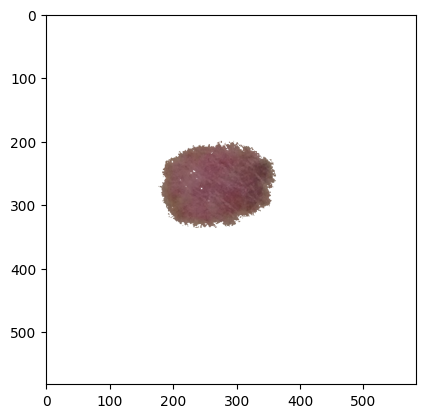

In [125]:
print("the shape of true_mole_pos: ",true_mole_pos.shape)
x=true_mole_pos[:,0]  # x_coordinate of true moles position
y=true_mole_pos[:,1]  # y_coordinate of true moles position
im_only_mole[x,y,...]=im_or[x,y,...] # Place the true_mole_pos into the blank white image.
plt.figure()
plt.imshow(im_only_mole, interpolation=None)


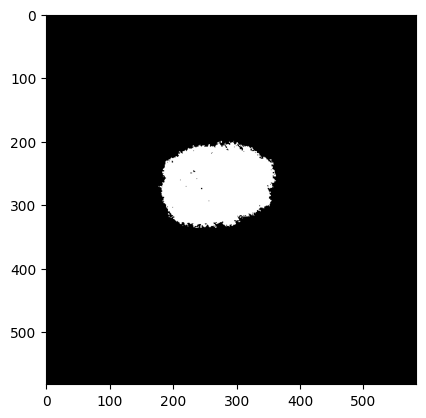

In [126]:
# Create a binary image where mole pixels are set to 1 (white), and all others are 0 (black)
im_mole = np.zeros(im_or.shape) # Initialize a black image
im_mole[x,y]=1 # Set the mole pixel positions to 1 (highlighting the mole)
plt.figure()
plt.imshow(im_mole, interpolation=None)

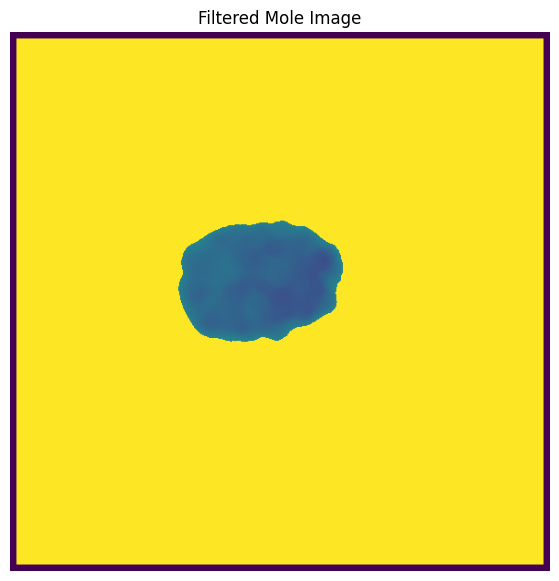

In [127]:
# filtering the image
# Initialize im_mole_pos_red as the red channel of im_only_mole
im_mole_pos_red = im_only_mole[..., 1]  # the red channel is the first channel
im_mole_pos_red_filt=0*im_mole_pos_red # create an empty array to store the results of filtered data later.
delta = 7  # Specifies the size of the neighborhood for the median filter. Setting delta = 7 means the neighborhood around each pixel will be a square of size (2 * delta + 1) x (2 * delta + 1) (15x15 in this case).

for kr in range(delta, N1-delta):    # N1=Height of im_or
    for kc in range(delta,N2-delta): # N2= width of im_or
        sub=im_mole_pos_red[kr-delta:kr+delta,kc-delta:kc+delta] # xtracts a local square region (neighborhood) centered at the current pixel (kr, kc). This region includes all pixels within delta pixels above, below, left, and right of (kr, kc).
        im_mole_pos_red_filt[kr,kc]=np.median(sub) # replaces the current pixel value with the median of its neighborhood.

# Display the filtered image
plt.figure(figsize=(7, 7))
plt.imshow(im_mole_pos_red_filt)
plt.title("Filtered Mole Image")
plt.axis("off")
plt.show()

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
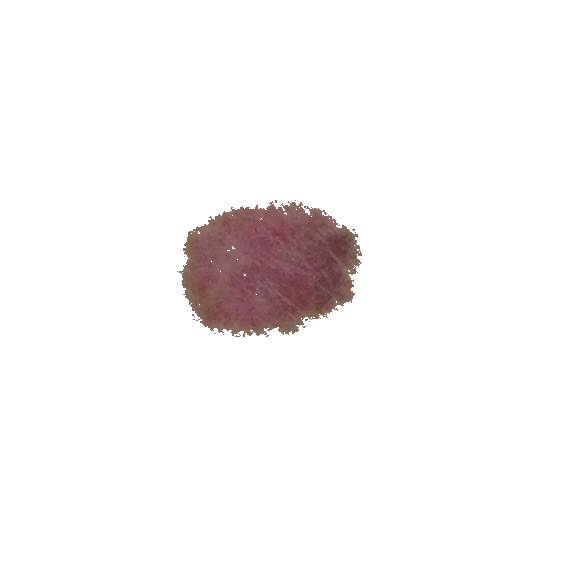

In [128]:
im_only_mole  #red values